### Working notebook: please skip

In [43]:
# split X_train
X_train2, X_test2, y_train2, y_test2, census_train2, census_test2 = train_test_split(X_train, y_train, census_train, test_size=0.33, random_state=42)

In [44]:
clf2 = lgb.LGBMClassifier(random_state=42)
clf2.fit(X_train2, y_train2)
# add predicted class in the adult_test (decoding back)
y_pred_b2 = clf.predict(X_test2)
census_test2['pred_b2'] = encoders['class'].inverse_transform(y_pred_b2)

In [45]:
#y_pred_bt = clf.predict(X_train)
#census_train['pred_bt'] = encoders['class'].inverse_transform(y_pred_bt)
disc_bt = dd.DD(census_test2[disc_all+['pred_b2']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_b2=False', trueBadItem='class=False',
               codes=disc_b.codes) # extends the coding of items as disc_a 

In [46]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_bt = lambda ctg: eop_mean(ctg, disc_bt)

def metric_bt_abs(ctg):
    v = eop_mean(ctg, disc_bt)
    return abs(v) if v is not None else v

In [63]:
# Extract contingency tables: 
ctgs_bt = disc_bt.extract(testCond=metric_bt, minSupp=-10, topk=1000)

In [71]:
# sequential covering algorithm: 10 contingency tables
covers, residuals, times, uncovered, ctg_cov, ctg_uncov = disc_bt.cover_n([ctg for _,ctg in ctgs_bt], metric_bt_abs, 10)
print('Total protected:', sum(residuals)+len(uncovered))
print('Total protected covered:', sum(residuals))
print('% covered: {:.2f}%'.format(100*sum(residuals)/(sum(residuals)+len(uncovered))))
# OR's of covering contexts and any protected
#disc_bt.print(ctg_cov)
#print("Metric = {:f}".format(metric_bt(ctg_cov)))

Total protected: 80847
Total protected covered: 478
% covered: 0.59%


In [72]:
# Cover contingency tables
sum_rd = cnt_rd = i = 0
for ctg, res in zip(covers, residuals):
    print('-----\nCT', i, 'covered', res)
    i += 1
    disc_bt.print(ctg)
    print("Metric = {:f}".format(metric_bt(ctg)))
    sum_rd += metric_bt(ctg)*ctg.n1()
    cnt_rd += ctg.n1()
print('-----\nAverage metric = {:f}'.format(sum_rd/cnt_rd))

-----
CT 0 covered 37
-----
Context STATE=MD AND WKHPgroup=>40
Size = 1809  Perc = 0.49%
RAC1P=Some Other Race alone                    RAC1P=White alone
           |pred_b2=False|pred_b2=True|                    |pred_b2=False|pred_b2=True|    
class=False|           22|           0|  22     class=False|            8|         357| 365
class=True |           15|           0|  15     class=True |            1|         965| 966
           |           37|           0|  37                |         1322|           9|1331
Metric = 0.982677
-----
CT 1 covered 81
-----
Context STATE=NJ AND WKHPgroup=>40
Size = 2695  Perc = 0.73%
RAC1P=Some Other Race alone                    RAC1P=White alone
           |pred_b2=False|pred_b2=True|                    |pred_b2=False|pred_b2=True|    
class=False|           46|           0|  46     class=False|            1|         483| 484
class=True |           35|           0|  35     class=True |            0|        1646|1646
           |           81|    

In [73]:
# switch to test set
all_covered = disc_b.itDB.cover_none()
for c in covers:
    all_covered |= disc_b.itDB.cover(c.ctx)

In [74]:
if False:
    all_covered = disc_b.itDB.cover_none()
    for x, d in zip(xs, descs):
        if abs(x)>0.4:
            dec = [disc_b.codes[v] for v in d]
            print(x, d, dec)
            all_covered |= disc_b.itDB.cover(dec)

In [75]:
len(all_covered)

29535

In [76]:
# selected = all - covered
sel = list(set(range(len(census_test)))-set(all_covered))
census_test_r = census_test.iloc[sel,:]
print('Coverage', len(sel)/len(census_test))

Coverage 0.9462300991288676


In [77]:
disc_r = dd.DD(census_test_r[disc_all+['pred_b']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_b=False', trueBadItem='class=False', 
               codes=disc_b.codes) # extends the coding of items as disc_a 

In [78]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_r = lambda ctg: eop_mean(ctg, disc_r)

In [79]:
# each protected vs unprotected
for ctg in disc_r.ctg_global():
    disc_r.print(ctg)
    print("Metric = {:f}".format(metric_r(ctg)))

-----
Context ALL
Size = 519750  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       35222|        599| 35821     class=False|      212152|      41348|253500
class=True |       10272|        820| 11092     class=True |       84376|      65471|149847
           |       45494|       1419| 46913                |      106819|     296528|403347
Metric = 0.348295
-----
Context ALL
Size = 519750  Perc = 100.00%
RAC1P=Two or More Races                         RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|        8761|        685|  9446     class=False|      212152|      41348|253500
class=True |        2716|        996|  3712     class=True |       84376|      65471|149847
           |       11477|       1681| 13158                |      106819|     296528|403347
Metric = 0.153903


In [93]:
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_r, metric_r)
print('mean before', np.mean([abs(x) for x in xs]), 'after', np.mean([abs(y) for y in ys]), 'len', len(xs))
for x, y, d in zip(xs, ys, descs):
    print(x,y,d)

mean before 0.3216297936836959 after 0.30040320527186376 len 230
0.3237597911227154 0.3237597911227154 ('STATE=AL', 'RAC1P=Black or African American alone')
0.3237597911227154 0.3237597911227154 ('STATE=AL', 'RAC1P=Two or More Races')
0.038045505408429714 0.038045505408429714 ('STATE=AL', 'RAC1P=Asian alone')
0.3237597911227154 0.3237597911227154 ('STATE=AL', 'RAC1P=Some Other Race alone')
0.3237597911227154 0.3237597911227154 ('STATE=AL', 'RAC1P=American Indian alone')
0.6711111111111111 0.6711111111111111 ('STATE=AK', 'RAC1P=Black or African American alone')
0.3983838383838384 0.3983838383838384 ('STATE=AK', 'RAC1P=Two or More Races')
0.4711111111111111 0.4711111111111111 ('STATE=AK', 'RAC1P=Asian alone')
0.6711111111111111 0.6711111111111111 ('STATE=AK', 'RAC1P=American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other')
0.6711111111111111 0.6711111111111111 ('STATE=AK', 'RAC1P=Alaska Native alone')
0.3875338753387534 0.38753387

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_19436\3957971674.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)


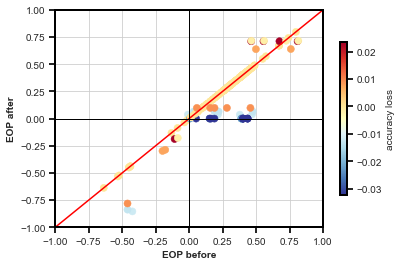

In [94]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP before", fontweight="bold")
plt.ylabel("EOP after", fontweight="bold")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
#plt.clim(-.1,.1)
#plt.savefig('fig1.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [82]:
y_pred_r = encoders['class'].transform(census_test_r['pred_b'])
y_test_r = encoders['class'].transform(census_test_r['class'])
X_test_r = X_test.iloc[sel,:]
summary_r = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test_r,
                          y_pred=y_pred_r,
                          sensitive_features=X_test_r['RAC1P'])
summary_r.overall-summary_r.by_group

RAC1P
0.0    0.378105
1.0    0.354995
2.0    0.422222
3.0   -0.310836
4.0    0.348295
5.0    0.281797
6.0     0.41572
7.0    0.153903
8.0   -0.014697
Name: true_positive_rate, dtype: object

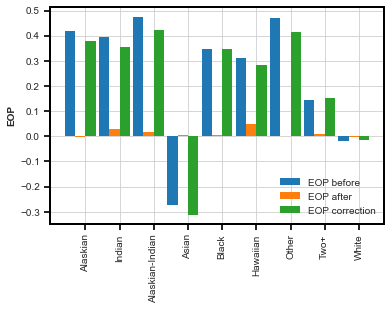

In [83]:
X_axis = np.arange(len(pretty_rac1p))
plt.bar(X_axis - 0.45, summary_b.overall-summary_b.by_group, 0.3, label='EOP before')
plt.bar(X_axis - 0.15, summary_a.overall-summary_a.by_group, 0.3, label='EOP after')
plt.bar(X_axis + 0.15, summary_r.overall-summary_r.by_group, 0.3, label='EOP correction')
plt.xticks(X_axis, pretty_rac1p)
plt.xticks(rotation=90)
plt.legend(loc=4)
plt.ylabel("EOP", fontweight="bold")
#plt.savefig('fig0.pdf', bbox_inches='tight', dpi=400)
plt.show()